In [1]:
# load env ------------------------------------------------------------------------
import os
import utils

utils.load_env()
os.environ['LANGCHAIN_TRACING_V2'] = "false"

# debug ------------------------------------------------------------------
from langchain.globals import set_debug, set_verbose
set_verbose(True)
set_debug(False)
from langchain_core.messages import (
    AIMessage, 
    HumanMessage,
    ToolMessage
)
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

## Define Tool Node
from typing import Literal

from agents import(
    AgentState,
    agent_names,
    analyst_node,
    data_collector_node,
    data_analyst_node,
    reporter_node,
)
from tools import get_tools_output, all_tools
from chat_history import save_chat_history, load_chat_history

tool_node = ToolNode(all_tools)


def router(state) -> Literal["call_tool", "__end__", "data_collector", "reporter", "analyst"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "data_collector" in last_message.content:
        return "data_collector"
    if "reporter" in last_message.content:
        return "reporter"
    if "analyst" in last_message.content:
        return "analyst"
    else:
        return "continue"


## Workflow Graph ------------------------------------------------------------------------
workflow = StateGraph(AgentState)

# add agent nodes
workflow.add_node('analyst', analyst_node)
workflow.add_node('data_collector', data_collector_node)
workflow.add_node('data_analyst', data_analyst_node)
workflow.add_node('reporter', reporter_node)
    
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "analyst",
    router,
    {
        "call_tool": "call_tool", 
        "__end__": END,
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "data_collector",
    router,
    {
        "call_tool": "call_tool", 
        "continue": "data_analyst", 
        }
)

workflow.add_conditional_edges(
    "data_analyst",
    router,
    {
        "call_tool": "call_tool", 
        "continue": "reporter", 
        }
)

workflow.add_conditional_edges(
    "reporter",
    router,
    {
        "__end__": END,
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {name:name for name in agent_names},
)

workflow.add_edge(START, "analyst")
graph = workflow.compile()

def submitUserMessage(
    user_input:str, 
    user_id:str="test", 
    keep_chat_history:bool=False, 
    return_reference:bool=False, 
    verbose:bool=False,
    recursion_limit:int=20
    ) -> str:
    
    chat_history = load_chat_history(user_id=user_id) if keep_chat_history else []
    chat_history = chat_history[-8:]
    
    # memory only keep chat history only along agents.
    internal_level_memory = MemorySaver()
    graph = workflow.compile(checkpointer=internal_level_memory)

    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    user_input
                )
            ],
            "chat_history": chat_history
        },
        # Maximum number of steps to take in the graph
        {"recursion_limit": recursion_limit, "thread_id":"a"},
    )
    
    if not verbose:
        events = [e for e in events]
        response = list(events[-1].values())[0]
    else:
        for e in events:
            a = list(e.items())[0]
            a[1]['messages'][0].pretty_print()
        
        response = a[1]
    
    response = response["messages"][0].content
    response = response.replace("FINALANSWER:", "")
    response = response.replace("FINALANSWER,", "")
    response = response.replace("FINALANSWER", "")
    
    restrict_str_size = lambda response: response[200:] + "..."
    
    if keep_chat_history:
        save_chat_history(bot_message=restrict_str_size(response), human_message=user_input, user_id=user_id)
    
    if return_reference:
        return response, get_tools_output()
    else:
        return response

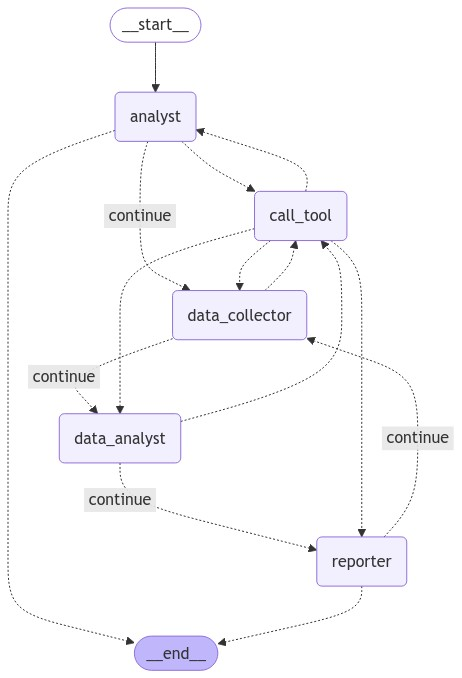

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [3]:
result = submitUserMessage("วิเคราะห์ธุรกิจโรงแรมแถวซอยมิตรภาพ 8", keep_chat_history=True, return_reference=True, verbose=True)

================================== Ai Message ==================================
Name: analyst

I will identify the location and keyword from your request. 

- **Location**: ซอยมิตรภาพ 8
- **Keyword**: โรงแรม (hotel)

I will now pass this information to the Data Collector for further analysis.
================================== Ai Message ==================================
Name: data_collector
Tool Calls:
  find_place_from_text (call_eWnTyuFBpZ6N5ewV3j2VlWnv)
 Call ID: call_eWnTyuFBpZ6N5ewV3j2VlWnv
  Args:
    location: ซอยมิตรภาพ 8
================================= Tool Message =================================
Name: find_place_from_text


    address: ซอย มิตรภาพ ๘ ตำบลในเมือง อำเภอเมืองนครราชสีมา นครราชสีมา 30000 ประเทศไทย

    location_name: ซอย มิตรภาพ ๘

    
================================== Ai Message ==================================
Name: data_collector
Tool Calls:
  get_geometric_data (call_KKN44lEDX3AQNbXyYcxuzck6)
 Call ID: call_KKN44lEDX3AQNbXyYcxuzck6
  Args:
    input

In [4]:
result = submitUserMessage("Analyze the feasibility of opening a restaurant near Siam Paragon", keep_chat_history=True, return_reference=True, verbose=True)

================================== Ai Message ==================================
Name: analyst

I will identify the location and keyword from your request. 

- **Location**: Near Siam Paragon
- **Keyword**: Restaurant

I will now pass this information to the Data Collector for further analysis.
================================== Ai Message ==================================
Name: data_collector
Tool Calls:
  get_geometric_data (call_SsDKlHxZHRef8ECoogGgqa4O)
 Call ID: call_SsDKlHxZHRef8ECoogGgqa4O
  Args:
    input_dict: {'keyword': 'restaurant', 'location_name': 'Siam Paragon'}
================================= Tool Message =================================
Name: get_geometric_data


    location: สยามพารากอน

    **nearby competitors**
    number of restaurant: 21

        - **Shree Bhavan Pure South Indian Vegetarian Restaurant**
        	address: 120 Pratunam Market, 45 Ratchaprarop Rd, Thanon Phaya Thai, Ratchathewi
        	rating: 4.9
        
        - **Royal Kitchen Indian Fo

In [5]:
result = submitUserMessage("วิเคราะห์ร้านอาหารไทยแถวลุมพินี เซ็นเตอร์ ลาดพร้าว วิเคราะห์ความเป็นไปได้ถ้าต้องการขายข้าวในราคา 300", keep_chat_history=True, return_reference=True, verbose=True)


================================== Ai Message ==================================
Name: analyst

I will first identify the location and keyword from your request.

- **Location**: ลุมพินี เซ็นเตอร์ ลาดพร้าว
- **Keyword**: ร้านอาหารไทย

Now, I will pass this information to the Data Collector for further analysis.
================================== Ai Message ==================================
Name: data_collector
Tool Calls:
  get_geometric_data (call_V2AIYGEVBOPdH5XpIAROM7Pv)
 Call ID: call_V2AIYGEVBOPdH5XpIAROM7Pv
  Args:
    input_dict: {'keyword': 'ร้านอาหารไทย', 'location_name': 'ลุมพินี เซ็นเตอร์ ลาดพร้าว'}
================================= Tool Message =================================
Name: get_geometric_data


    location: ลุมพินี เซ็นเตอร์ ลาดพร้าว 111

    **nearby competitors**
    number of ร้านอาหารไทย: 21

        - **ร้านเจ๊อัง แซ่บ นรก แตก**
        	address: QJ9V+56X, Thanon Happy Land Sai 2, Khlong Chan, Bang Kapi District
        	rating: 5
        
        - **ตำแซ่

In [6]:
result = submitUserMessage("รายงานการวิเคราะห์อสังหาริมทรัพย์ในคลองพระอุดม ปากเกร็ด นนทบุรี", keep_chat_history=True, return_reference=True, verbose=True)


================================== Ai Message ==================================
Name: analyst

I will extract the location and keyword from your request. 

- **Location**: คลองพระอุดม, ปากเกร็ด, นนทบุรี
- **Keyword**: อสังหาริมทรัพย์ (real estate)

I will now pass this information to the Data Collector for further analysis.
================================== Ai Message ==================================
Name: data_collector
Tool Calls:
  get_geometric_data (call_eQDTZjVx3C2STdNTHZAiIzQb)
 Call ID: call_eQDTZjVx3C2STdNTHZAiIzQb
  Args:
    input_dict: {'keyword': 'อสังหาริมทรัพย์', 'location_name': 'คลองพระอุดม, ปากเกร็ด, นนทบุรี'}
================================= Tool Message =================================
Name: get_geometric_data


    location: คลองพระอุดม

    **nearby competitors**
    number of อสังหาริมทรัพย์: 3

        - **โกดัง คลังเก็บสินค้า โรงงาน ให้เช่า ลาดหลุมแก้ว by คุณ ณรงค์**
        	address: 74 Khu Bang Luang, Lat Lum Kaeo District
        	rating: 5
        
  

KeyboardInterrupt: 